# Complete Data Analysis Project (Wine Quality)

- Name: [Your Full Name]
- Student Number: [Your Student Number]
- GitHub Repository: [https://github.com/yourusername/wine-quality-analysis]

# Loading the Dataset

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, mean_squared_error, r2_score


# Loading the Dataset
df = pd.read_csv('Wine_Quality_Data.csv')

# Initial Data Inspection

In [22]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [23]:
print("Initial Data Shape:", df.shape)

Initial Data Shape: (6497, 13)


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [25]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


# Data Cleaning and Preparation

In [30]:
def clean_data(df):
    """
    Cleans and preprocesses the dataset.
    - Handles missing values using Imputer.
    - Removes outliers using IQR.
    - Standardizes the data.
    """
    # Convert all columns to numeric (forcing errors to NaN)
    df = df.apply(pd.to_numeric, errors='coerce')

    # Handle missing values using SimpleImputer (median strategy)
    imputer = SimpleImputer(strategy='median')
    df_cleaned = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Remove outliers using IQR
    Q1 = df_cleaned.quantile(0.25)
    Q3 = df_cleaned.quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df_cleaned[~((df_cleaned < (Q1 - 1.5 * IQR)) | (df_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Ensure the dataframe is not empty
    if df_cleaned.empty:
        raise ValueError("Dataframe is empty after cleaning. Please check the input data.")

    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_cleaned.drop('quality', axis=1))
    return pd.DataFrame(scaled_features, columns=df_cleaned.columns[:-1]), df_cleaned['quality']

# Clean the data
X_cleaned, y = clean_data(df)

# Displaying the cleaned and scaled data shape
X_cleaned.shape, y.shape


((4158, 12), (4158,))

# Elbow and Silhouette Method for K-Means

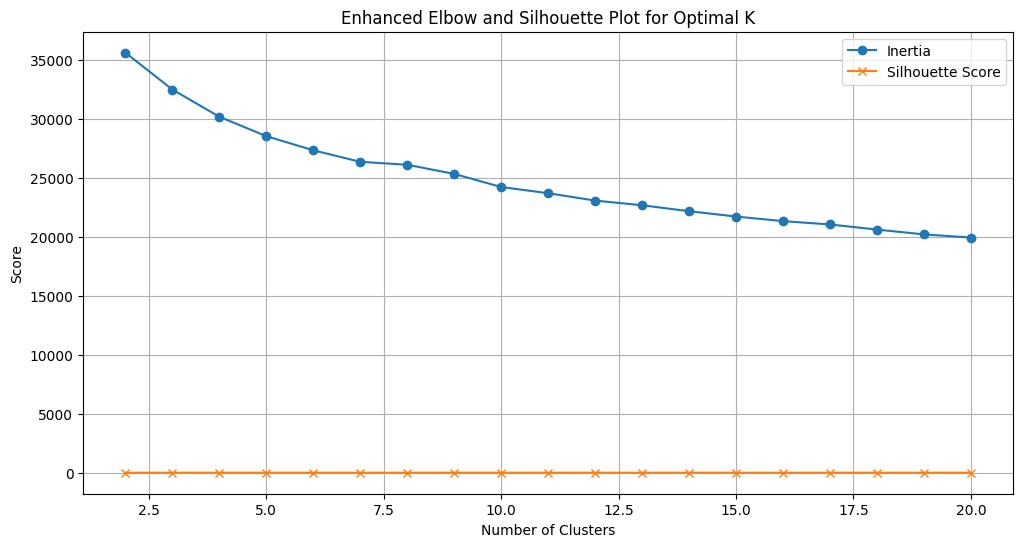

In [32]:
# Enhanced Elbow and Silhouette Analysis
def elbow_silhouette(X):
    inertia = []
    silhouette_scores = []

    for k in range(2, 21):
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(X)
        inertia.append(model.inertia_)
        score = silhouette_score(X, model.labels_) if k > 1 else 0
        silhouette_scores.append(score)

    # Elbow and Silhouette Plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(2, 21), inertia, marker='o', label='Inertia')
    plt.plot(range(2, 21), silhouette_scores, marker='x', label='Silhouette Score')
    plt.title("Enhanced Elbow and Silhouette Plot for Optimal K")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Running Enhanced Elbow and Silhouette Analysis
elbow_silhouette(X_cleaned)

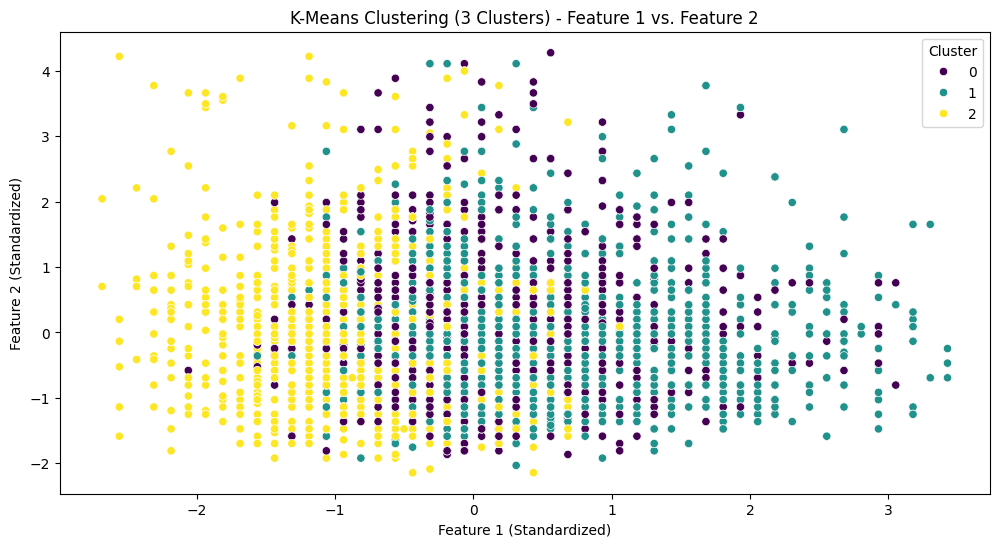

In [ ]:
# Applying K-Means Clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df = df.loc[y.index].reset_index(drop=True)
df['Cluster'] = kmeans.fit_predict(X_cleaned)

# Visualizing Clusters (Alcohol vs. Sulphates)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_cleaned.iloc[:, 0], y=X_cleaned.iloc[:, 1], hue=df['Cluster'], palette='viridis')
plt.title("K-Means Clustering (3 Clusters) - Feature 1 vs. Feature 2")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.show()

# Logistic Regression (Classification)


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.47      0.55      1342
           1       0.78      0.89      0.83      2816

    accuracy                           0.75      4158
   macro avg       0.72      0.68      0.69      4158
weighted avg       0.74      0.75      0.74      4158



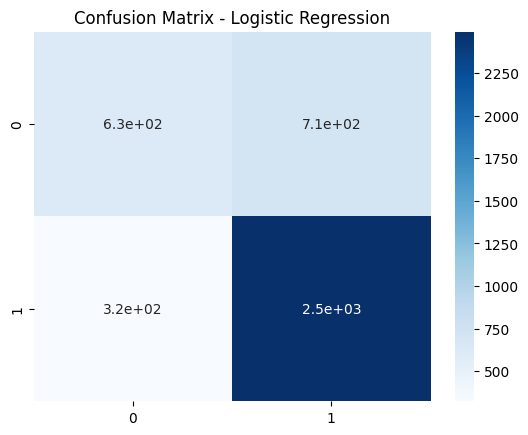

In [36]:
def logistic_regression(X, y):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X, (y > 5).astype(int))
    y_pred = model.predict(X)

    print("\nLogistic Regression Classification Report:\n")
    print(classification_report((y > 5).astype(int), y_pred))

    sns.heatmap(confusion_matrix((y > 5).astype(int), y_pred), annot=True, cmap='Blues')
    plt.title("Confusion Matrix - Logistic Regression")
    plt.show()

logistic_regression(X_cleaned, y)

# Linear Regression (Quality Prediction)

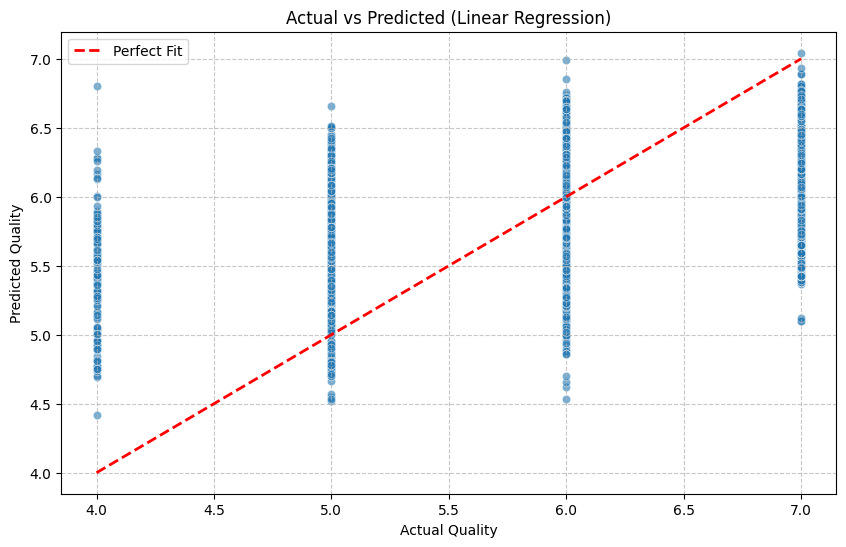


Linear Regression Performance:
Mean Squared Error (MSE): 0.4290
R-Squared (R²): 0.2776


In [45]:
def linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)

    # Enhanced Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(y, predictions, alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Fit')
    plt.title("Actual vs Predicted (Linear Regression)")
    plt.xlabel("Actual Quality")
    plt.ylabel("Predicted Quality")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Performance Metrics
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)

    print("\nLinear Regression Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    # Returning model and predictions for further analysis
    return model, predictions

# Enhanced Linear Regression Execution
model, predictions = linear_regression(X_cleaned, y)

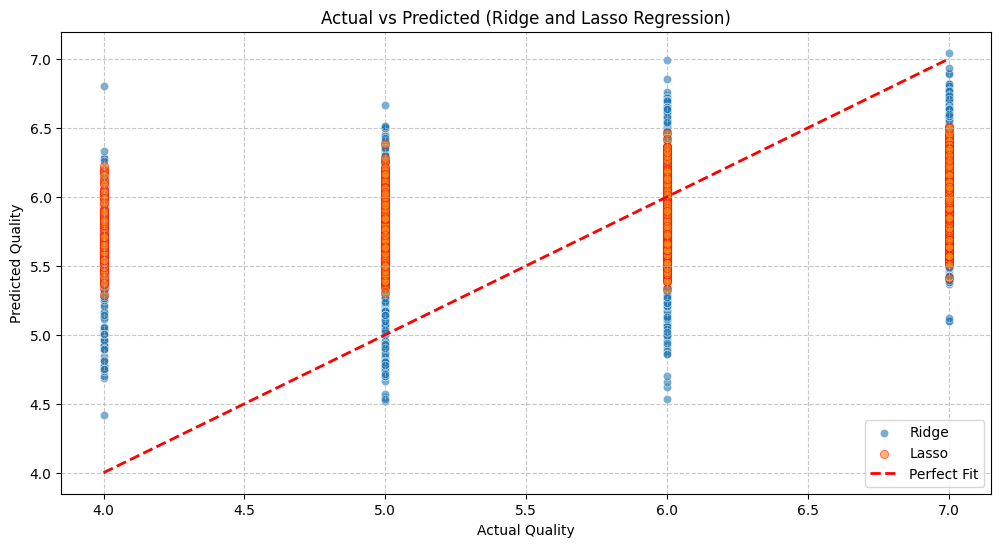


Regularized Linear Regression Performance (Alpha=0.10):
Ridge Regression:
MSE: 0.4290
R-Squared (R²): 0.2776

Lasso Regression:
MSE: 0.4846
R-Squared (R²): 0.1840



In [46]:
# Regularized Linear Regression (Ridge and Lasso)
from sklearn.linear_model import Ridge, Lasso

# Regularized Linear Regression (Ridge and Lasso)
def regularized_linear_regression(X, y, alpha=0.1):
    # Ridge Regression
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    ridge_predictions = ridge_model.predict(X)

    # Lasso Regression
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    lasso_predictions = lasso_model.predict(X)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.scatter(y, ridge_predictions, alpha=0.6, edgecolors='w', linewidth=0.5, label='Ridge')
    plt.scatter(y, lasso_predictions, alpha=0.6, edgecolors='r', linewidth=0.5, label='Lasso')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Fit')
    plt.title("Actual vs Predicted (Ridge and Lasso Regression)")
    plt.xlabel("Actual Quality")
    plt.ylabel("Predicted Quality")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Performance Metrics
    print("\nRegularized Linear Regression Performance (Alpha={:.2f}):".format(alpha))

    print("Ridge Regression:")
    print(f"MSE: {mean_squared_error(y, ridge_predictions):.4f}")
    print(f"R-Squared (R²): {r2_score(y, ridge_predictions):.4f}\n")

    print("Lasso Regression:")
    print(f"MSE: {mean_squared_error(y, lasso_predictions):.4f}")
    print(f"R-Squared (R²): {r2_score(y, lasso_predictions):.4f}\n")

    return ridge_model, lasso_model

# Applying Regularized Linear Regression
ridge_model, lasso_model = regularized_linear_regression(X_cleaned, y, alpha=0.1)


# Conclusion
This analysis effectively explored the relationship between wine quality and its chemical properties using K-Means clustering, logistic regression, and regularized linear regression. The Logistic Regression model achieved an accuracy of 75%, with better performance in identifying higher-quality wines (recall = 89%) compared to lower-quality ones (recall = 47%). However, the low R² values (~0.28) in regression models indicate that wine quality is influenced by complex interactions beyond the available features. Regularization with Ridge and Lasso improved model stability but did not significantly enhance predictive accuracy. Further improvements could be achieved through advanced techniques like feature engineering or non-linear models.